# Continious State Neural Circuit

#### Our first task is to create state neurons that will represent a continious variable.

First, we import required libraries.

In [169]:
%matplotlib inline

import nest
from nest import raster_plot as rplt
import numpy as np
import matplotlib.pyplot as plt

Then, we define our constants.

In [170]:
NUM_STATE_NEURONS = 5
NUM_STATES = 100

Let's create some state neurons.


In [171]:
nest.ResetKernel()

# Create states
states = [nest.Create("iaf_psc_alpha", NUM_STATE_NEURONS) for i in range(NUM_STATES)]
all_states = np.ravel(states).tolist()

# Create noise
noise = nest.Create('poisson_generator', 1, {'rate': 65000.})
nest.Connect(noise, all_states, 'all_to_all', {'weight': 1.})

Let's try to activate one of neuron pools.

In [172]:
# Create stimulus
stimulus = [nest.Create('poisson_generator', 1, {'rate': 0.}) for i in range(NUM_STATES)]
for i in range(NUM_STATES):
    nest.Connect(stimulus[i], states[i], 'all_to_all', {'weight': 1.})

In [173]:
# Create spike detector
sd = nest.Create('spike_detector')
nest.Connect(all_states, sd)

Test is network working.

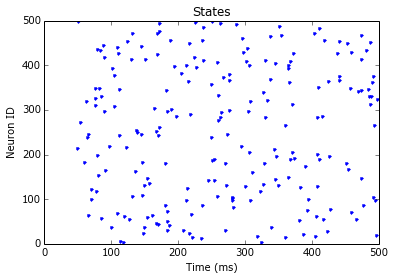

In [174]:
nest.ResetNetwork()
seed = np.random.randint(0, 1000000)
nest.SetKernelStatus({'rng_seeds': range(seed, seed + 1), 'grng_seed': seed})

nest.Simulate(500.0)

# Plot states
rplt.from_device(sd, hist=False, title='States')
rplt.show()

Now we want to attach Gaussian distribution to our state's spike generators.

First, import scipy.

In [175]:
from scipy.stats import norm

Let's distribute our means over the given interval.

In [176]:
# TODO: maybe I should rename some of the variables and functions

# Interval from point a to point b
a = -1.
b = 1.
interval_length = b - a

# Normal distribution standard deviation
# Maybe it shall depend on number of states, neurons and interval length
STD = 0.2

# Distributing means over interval
# I think there should be a better way to write this
# There also is some rounding error in division somewhere
means = [a + (i + 1) * (interval_length / (NUM_STATES + 1)) for i in range(NUM_STATES)]

def inputValue(value):
    
    # Values that are returned by pdf function to be applied to spike generator rate
    applied_values = []
    
    for i in range(NUM_STATES):
        applied_values.append(norm.pdf(value, means[i], STD))
    
    return applied_values

# print inputValue(0)

Now we apply our Gaussian tune curves to spike generators

In [177]:
# Scaling values of normal distribution to match spike generator rate
SCALE_RATE = 5000.

def applyValue(value):
    
    applied_values = inputValue(value)
    
    for i in range(NUM_STATES):
        nest.SetStatus(stimulus[i], {'rate': applied_values[i] * SCALE_RATE})


Let's test this shit

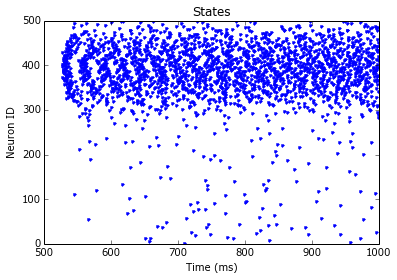

In [178]:
nest.ResetNetwork()
seed = np.random.randint(0, 1000000)
nest.SetKernelStatus({'rng_seeds': range(seed, seed + 1), 'grng_seed': seed})

# Our coordinate
applyValue(0.57)

nest.Simulate(500.0)

# Plot states
rplt.from_device(sd, hist=False, title='States')
rplt.show()

Next step is to connect state neurons to action neurons.
Action space will be represented as discrete (Paddle moves up, down, or stays).
But also it can be made continious (Action is not a paddle move direction, but a paddle distance change).

Implementation 1:
Discrete actions.
Paddle moves up, down, stays.
WTA circuit.